In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from math import sqrt

import sys


sys.path.append('../..')
# sys.path.append('../')

import optimneuralts
import viz_config
from utils import *


saves_path = '../saves'
%load_ext autoreload
%autoreload 2

In [2]:
def compute_n_inter(tens1:torch.Tensor, tens2:torch.Tensor):
    set1 = tens1.unique(dim=0).tolist()
    set2 = tens2.unique(dim=0).tolist()
    
    set1 = set([tuple(item) for item in set1])
    set2 = set([tuple(item) for item in set2])

    inter = set1 & set2
    n_inter = len(set1 & set2)
    percent_of_set1_in_set2 = n_inter / len(set1)

    return n_inter, percent_of_set1_in_set2

In [3]:
experiments = [
    "500_rx_100000_combis_10_patterns_5_bs512_warmup20000_nmembers512_valnoval_ldsTrue_trainevery10_patience25_usedecay_lrplateau_layers1_withnoise_exactdecay",
    "DE_500_rx_100000_combis_10_patterns_5_bs512_warmup20000_nmembers32_valnoval_ldsTrue_trainevery10_patience25_usedecay_lrplateau_layers1_withnoise_exactdecay",
]
dataset = "500_rx_100000_combis_10_patterns_5"
prefix = "500_1layer_withnoise_exactdecay"
n_trials = 10000
n_runs = 25
metrics_dict = {}
metrics = [
    "jaccards",
    "jaccards_alls",
    "ratio_apps_alls",
    "ratio_apps",
    "ratio_found_pats",
    "ratio_found_pats_alls",
    "losses",
    "dataset_losses",
    "n_inter_alls",
    "all_flagged_risks",
    "agents",
    "all_flagged_combis_idx",
]

combis, risks, pat_vecs, n_obs, n_dim = load_dataset(dataset, path_to_dataset="../datasets")


for exp in experiments:
    metrics_dict[exp] = {}
    for metric in metrics:
        metrics_dict[exp][metric] = []
        for run in range(n_runs):
            path = f"{saves_path}/{exp}/{metric}/{run}.pth"
            metrics_dict[exp][metric].append(torch.load(path))


In [4]:
colors = ["tab:orange", "tab:purple", "tab:green", "tab:red", "tab:cyan", "tab:brown"]
labels = ["Adam", "DE"]
interval = 200
upper_lim = 20100
labels_fn = "_vs_".join(labels)

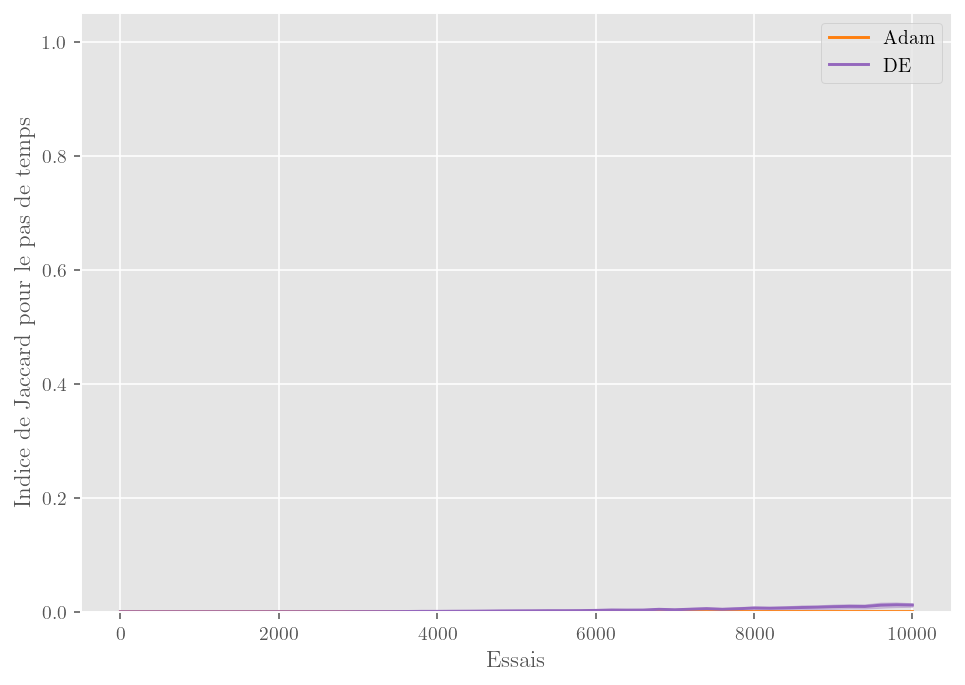

In [5]:
metric = "jaccards"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )


plt.xlabel("Essais")
plt.ylabel("Indice de Jaccard pour le pas de temps")
plt.legend()

plt.ylim(0, 1.05)

plt.tight_layout()


plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


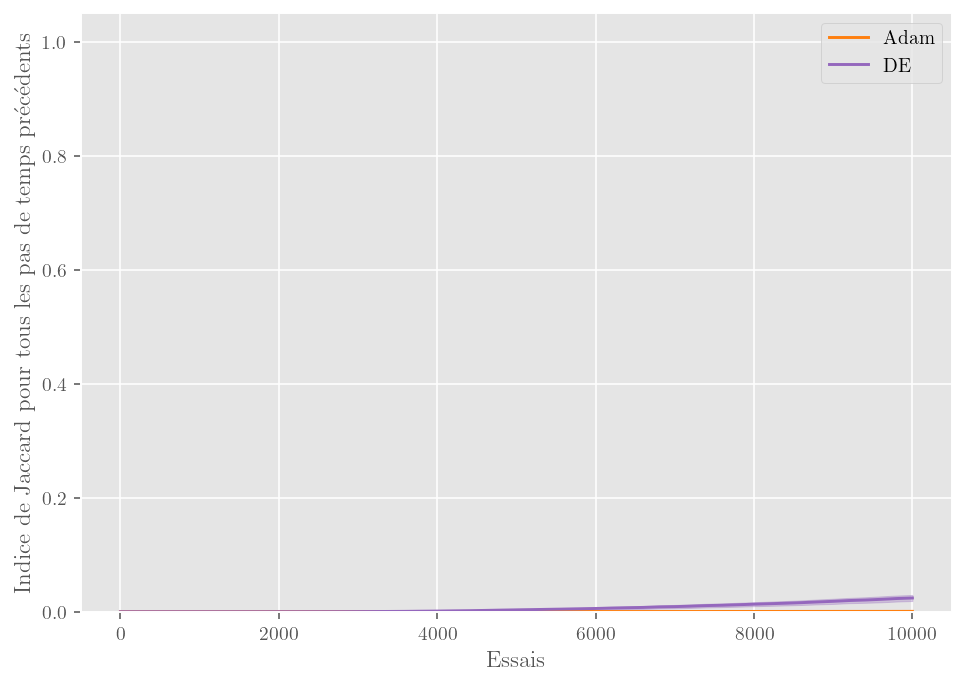

In [6]:
metric = "jaccards_alls"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Indice de Jaccard pour tous les pas de temps précédents")
plt.legend()

plt.ylim(0, 1.05)

plt.tight_layout()

# plt.show()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


/tmp/ipykernel_830100/4008741806.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quo/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_830100/4008741806.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quo/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


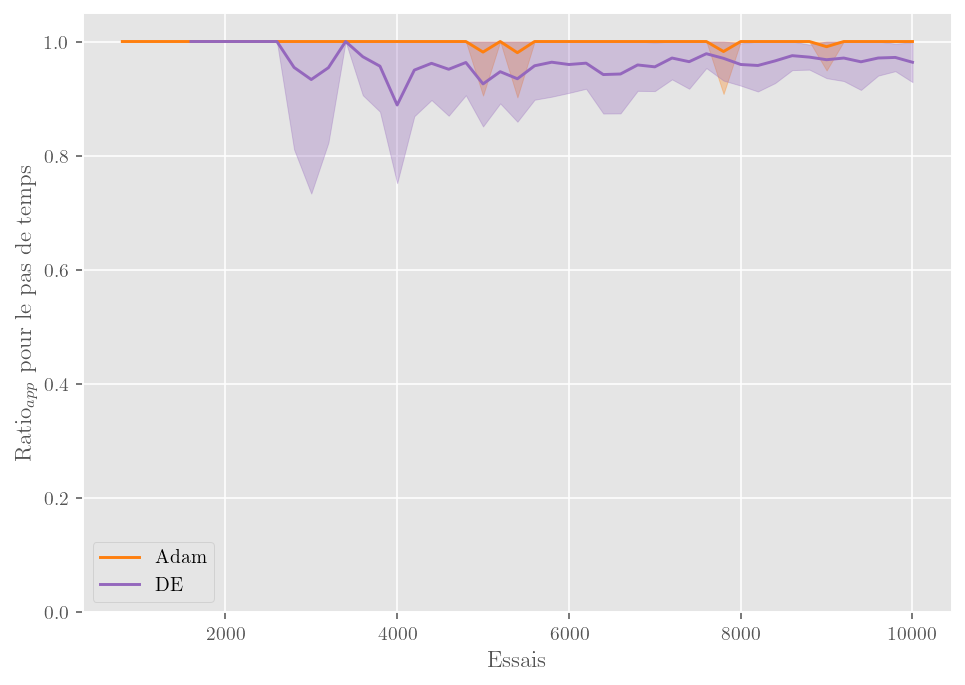

In [7]:
metric = "ratio_apps"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Ratio$_{app}$ pour le pas de temps")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
# plt.show()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


/tmp/ipykernel_830100/2003601589.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quo/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_830100/2003601589.py:4: RuntimeWarning: Mean of empty slice
  means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
/home/quo/Documents/Maitrise/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


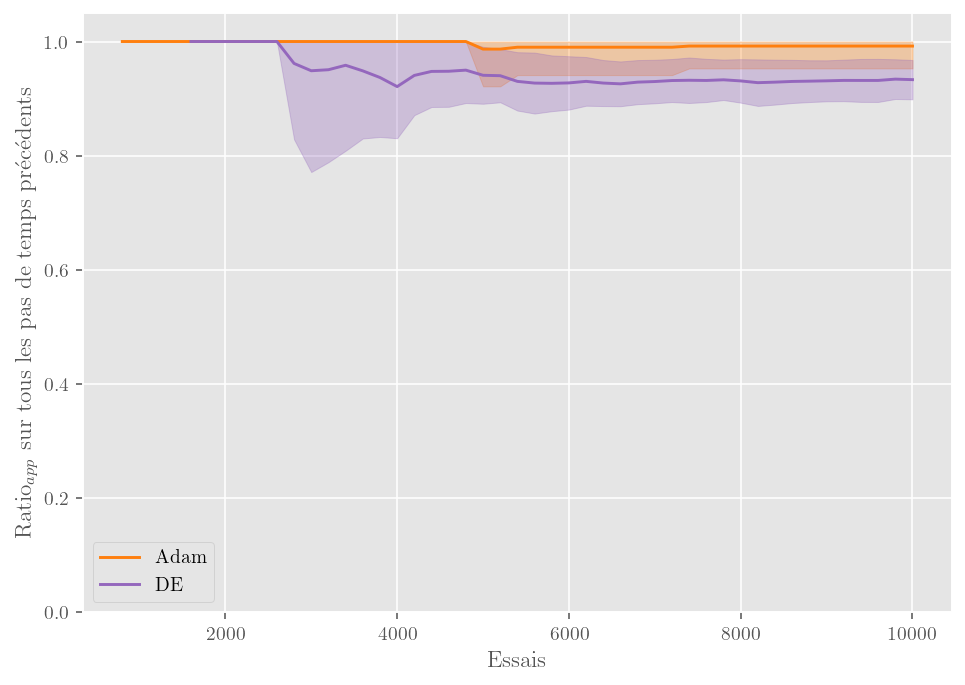

In [8]:
metric = "ratio_apps_alls"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[: (upper_lim // interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(
        x,
        np.clip(means - stds, 0, 1),
        np.clip(means + stds, 0, 1),
        color=colors[i],
        alpha=0.3,
    )
    plt.xlabel("Essais")
    plt.ylabel("Ratio$_{app}$ sur tous les pas de temps précédents")
plt.legend()
plt.ylim(0, 1.05)
plt.tight_layout()
# plt.show()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


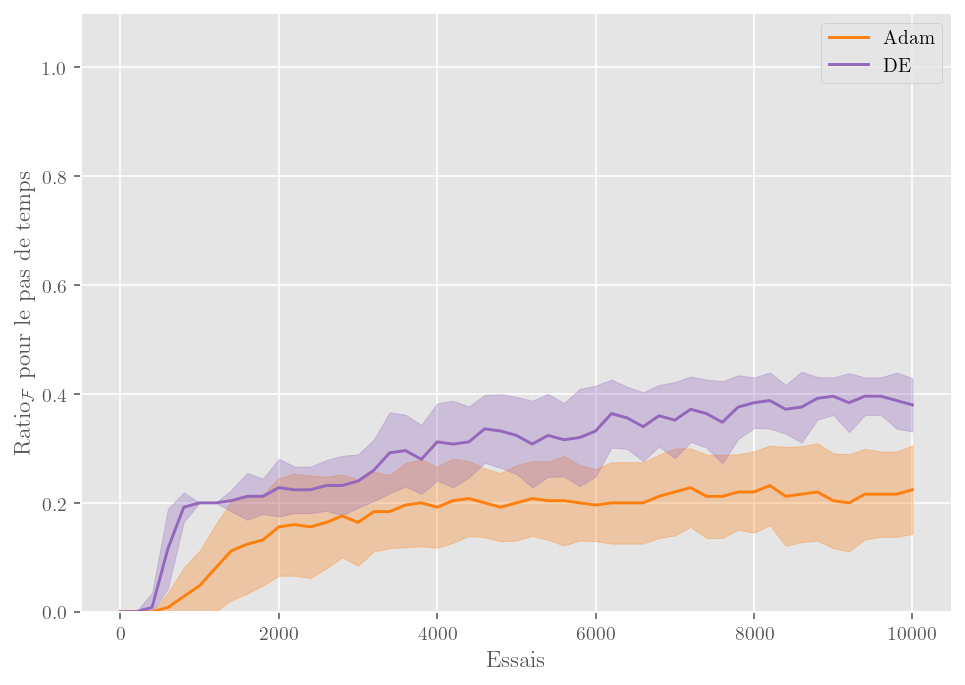

In [9]:
# Plot ratio found pat
metric = "ratio_found_pats"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Ratio$_{\mathcal{F}}$ pour le pas de temps")
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()

plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')



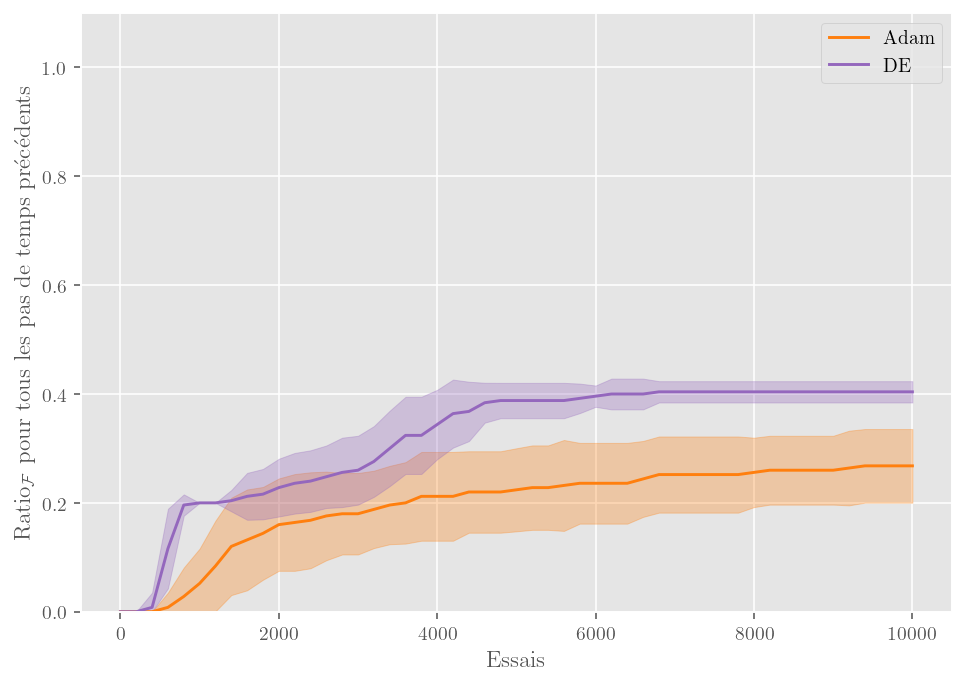

In [10]:
# Plot ratio found pat
metric = "ratio_found_pats_alls"

for i, exp in enumerate(metrics_dict.keys()):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval


    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), color=colors[i], alpha=0.3)
plt.ylabel("Ratio$_{\mathcal{F}}$ pour tous les pas de temps précédents")
plt.xlabel('Essais')
plt.legend()
plt.ylim(0, 1.1)
plt.tight_layout()


plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')



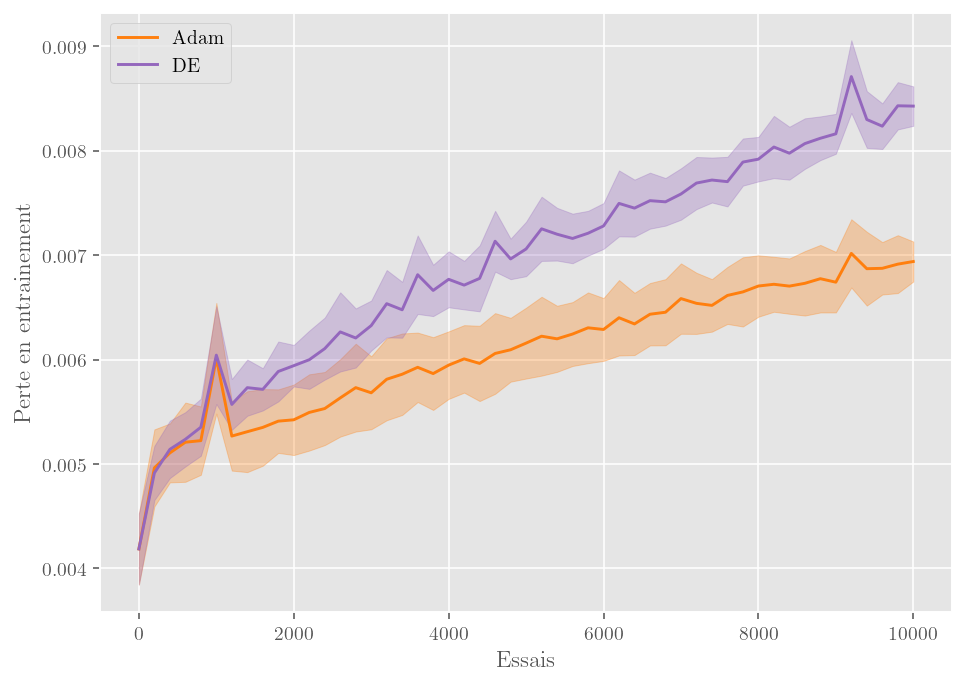

In [11]:
# Plot ratio found pat
metric = "losses"
for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte en entrainement")
plt.legend()
plt.tight_layout()

plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


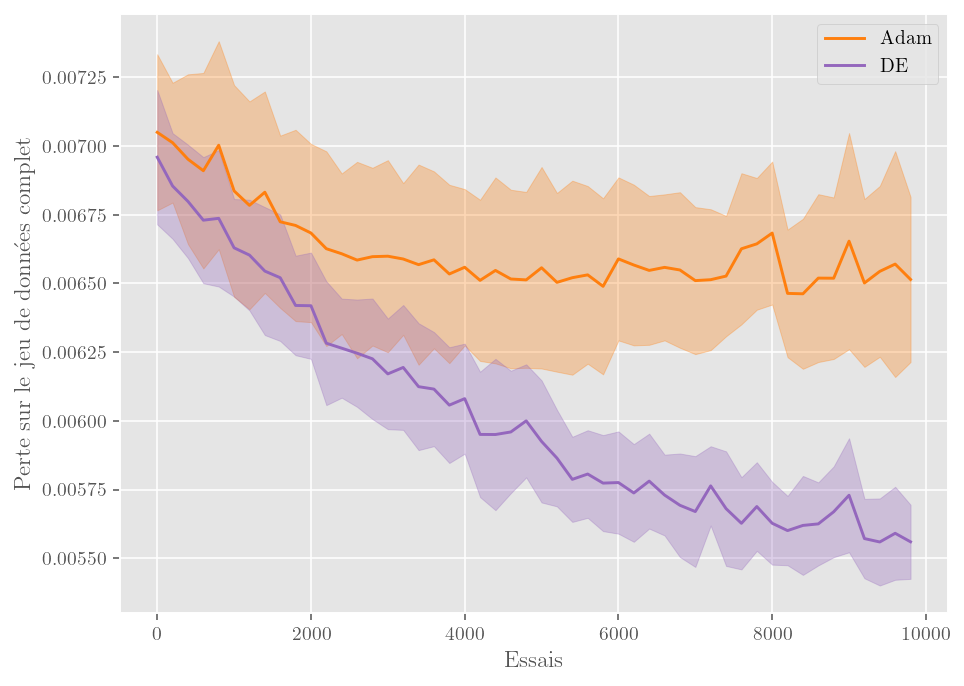

In [12]:
# Plot ratio found pat
metric = "dataset_losses"

for i, exp in enumerate(experiments):
    means = np.nanmean(metrics_dict[exp][metric], axis=0)[:(upper_lim // interval)]
    stds = np.nanstd(metrics_dict[exp][metric], axis=0)[:(upper_lim// interval)]
    x = np.arange(len(means)) * interval

    plt.plot(x, means, color=colors[i], label=labels[i])
    plt.fill_between(x, means - stds, means + stds, color=colors[i], alpha=0.3)
plt.xlabel('Essais')
plt.ylabel("Perte sur le jeu de données complet")
plt.legend()
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


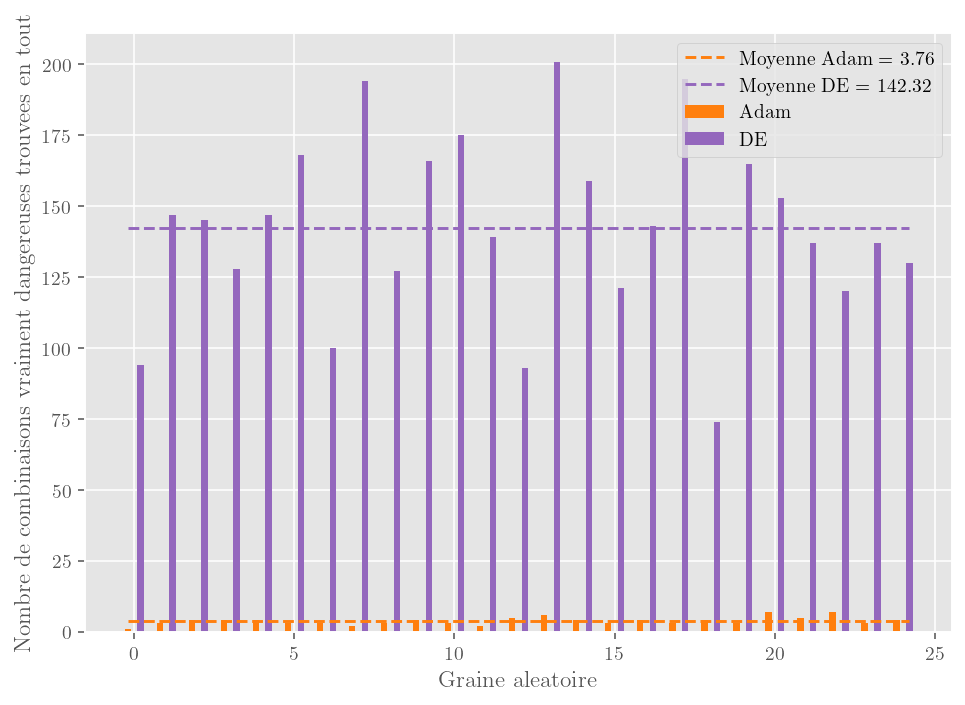

In [13]:
# Plot ratio found pat
metric = "n_inter_alls"
n_inter_means = []
for i, exp in enumerate(experiments):
    n_inters = []
    for j in range(n_runs):
        n_inters.append(metrics_dict[exp][metric][j][-1])

    seeds = np.arange(len(n_inters))
    n_inters = np.array(n_inters)
    mean = n_inters.mean()
    n_inter_means.append(mean)
    if i % 2 == 0:
        plt.bar(seeds - 0.2, n_inters, width=0.2, label=labels[i], color=colors[i])
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [mean] * 2,
            label=f"Moyenne {labels[i]} = {mean}",
            color=colors[i],
            linestyle="dashed",
        )
    else:
        plt.bar(seeds + 0.2, n_inters, width=0.2,label=labels[i], color=colors[i])
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [mean] * 2,
            label=f"Moyenne {labels[i]} = {mean}",
            color=colors[i],
            linestyle="dashed",
        )
plt.xlabel('Graine aleatoire')
plt.ylabel("Nombre de combinaisons vraiment dangereuses trouvees en tout")
plt.legend()
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_{labels_fn}')


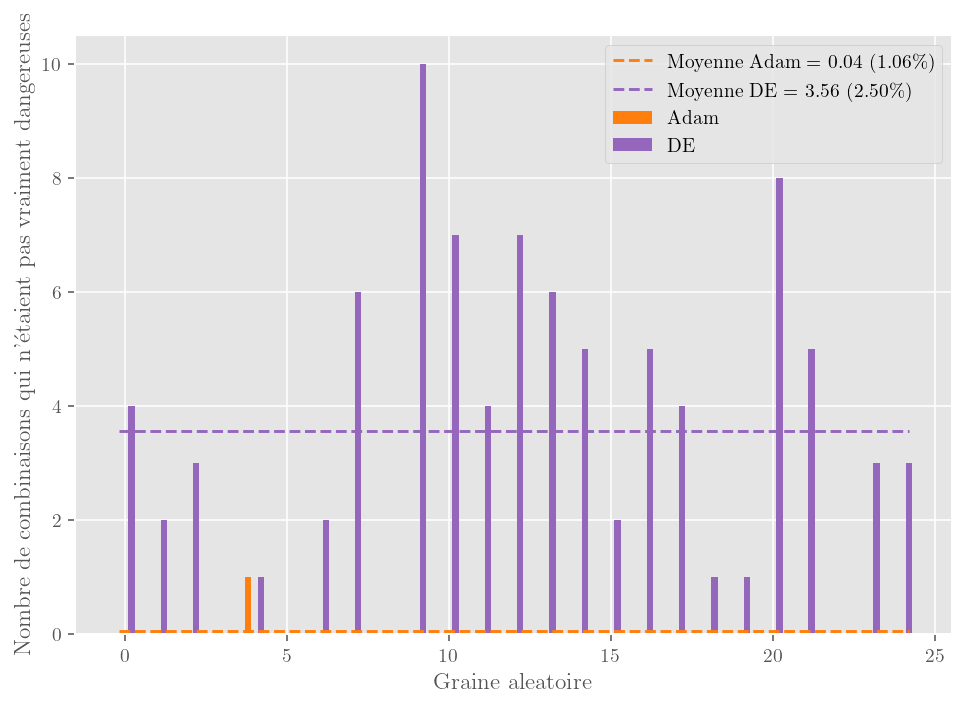

In [14]:
# Plot ratio found pat
metric = "all_flagged_risks"
thresh = 1.0
for i, exp in enumerate(experiments):
    n_flagged_below_thresh = []
    for j in range(n_runs):
        n_flagged_below_thresh.append(sum(metrics_dict[exp][metric][j] < thresh).item())

    seeds = np.arange(len(n_flagged_below_thresh))
    n_flagged_below_thresh = np.array(n_flagged_below_thresh)
    mean = n_flagged_below_thresh.mean()
    if i % 2 == 0:
        plt.bar(seeds - 0.2, n_flagged_below_thresh, width=0.2, label=labels[i], color=colors[i])
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [mean] * 2,
            label=f"Moyenne {labels[i]} = {mean} ({(mean / n_inter_means[i]) * 100:.2f}\%)",
            color=colors[i],
            linestyle="dashed",
        )
    else:
        plt.bar(seeds + 0.2, n_flagged_below_thresh, width=0.2, label=labels[i], color=colors[i])
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [n_flagged_below_thresh.mean()] * 2,
            label=f"Moyenne {labels[i]} = {mean} ({(mean / n_inter_means[i]) * 100:.2f}\%)",
            color=colors[i],
            linestyle="dashed",
        )
plt.xlabel('Graine aleatoire')
plt.ylabel("Nombre de combinaisons qui n'étaient pas vraiment dangereuses")
plt.legend()
plt.tight_layout()
plt.savefig(f'images/polypharmacy/perf/{prefix}_{metric}_below1_{labels_fn}')

In [15]:
def color_and_label_violinplot(violin, color, label):
    # color = violin["bodies"][0].get_facecolor().flatten()
    for pc in violin['bodies']:
        pc.set_color(color)

    violin["cbars"].set_color(color)
    # violin["cmeans"].set_color(color)
    violin["cmins"].set_color(color)
    violin["cmaxes"].set_color(color)
    
    fig_labels.append((mpatches.Patch(color=color), label))


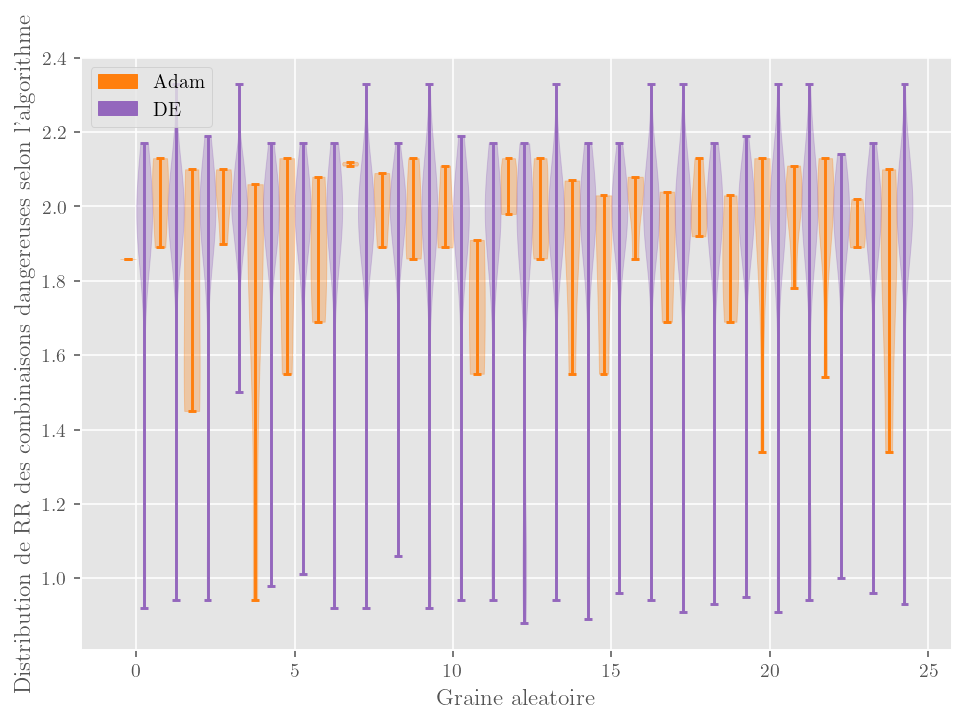

In [16]:
# Plot ratio found pat
fig_labels = []
metric = "all_flagged_risks"
for i, exp in enumerate(experiments):

    all_flagged_risks = metrics_dict[exp][metric]
    all_flagged_risks = [item.squeeze().tolist() for item in all_flagged_risks]

    if i % 2 == 0:
        color_and_label_violinplot(
            plt.violinplot(all_flagged_risks, np.array(list(range(n_runs))) - 0.25),
            label=labels[i],
            color=colors[i],
        )
    else:
        color_and_label_violinplot(
            plt.violinplot(all_flagged_risks, np.array(list(range(n_runs))) + 0.25),
            label=labels[i],
            color=colors[i],
        )


plt.xlabel("Graine aleatoire")
plt.ylabel("Distribution de RR des combinaisons dangereuses selon l'algorithme")
plt.legend(*zip(*fig_labels), loc=2)
plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_{metric}_where_flagged_{labels_fn}")


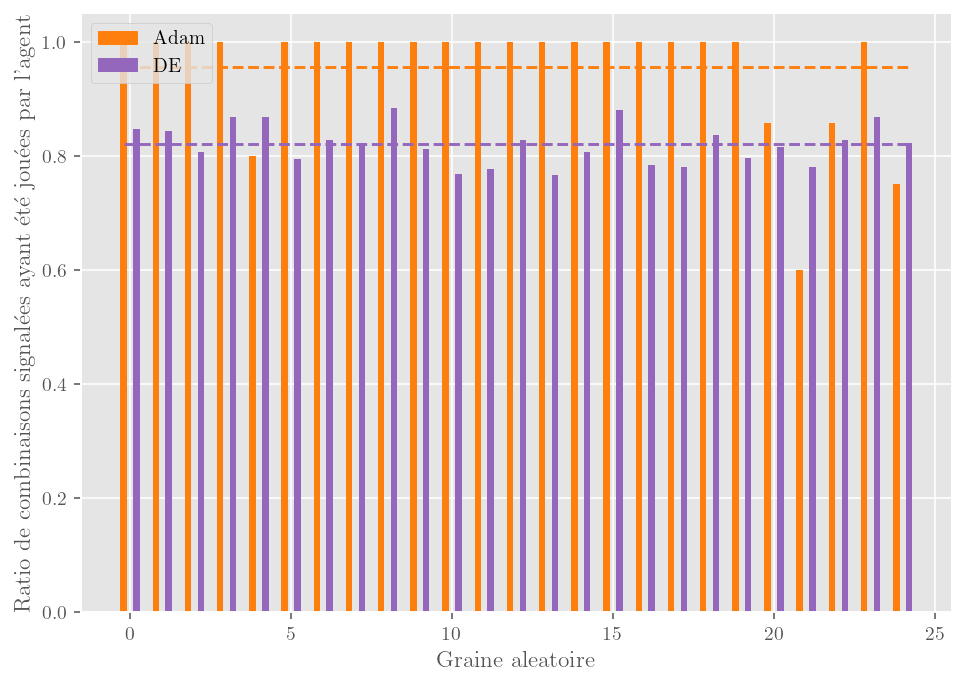

In [17]:
# Plot ratio found pat
metric = "all_flagged_combis_idx"
for i, exp in enumerate(experiments):
    n_inter, percent_of_flagged_in_train = [], []
    for j in range(n_runs):
        all_flagged_combis_idx = list(metrics_dict[exp][metric][j])
        all_flagged_combis = combis[all_flagged_combis_idx]
        training_set = metrics_dict[exp]["agents"][j].train_dataset.features
        inter, percent = compute_n_inter(all_flagged_combis, training_set)
        n_inter.append(inter)
        percent_of_flagged_in_train.append(percent)

    seeds = np.arange(n_runs)
    percent_of_flagged_in_train = np.array(percent_of_flagged_in_train)
    if i % 2 == 0:
        plt.bar(
            seeds - 0.2,
            percent_of_flagged_in_train,
            width=0.2,
            label=labels[i],
            color=colors[i],
        )
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [percent_of_flagged_in_train.mean()] * 2,
            label=f"Moyenne {labels[i]} = {percent_of_flagged_in_train.mean():.2f}",
            color=colors[i],
            linestyle="dashed",
        )
    else:
        plt.bar(
            seeds + 0.2,
            percent_of_flagged_in_train,
            width=0.2,
            label=labels[i],
            color=colors[i],
        )
        plt.plot(
            [min(seeds) - 0.2, max(seeds) + 0.2],
            [percent_of_flagged_in_train.mean()] * 2,
            label=f"Moyenne {labels[i]} = {percent_of_flagged_in_train.mean() * 100:.2f}",
            color=colors[i],
            linestyle="dashed",
        )


plt.xlabel("Graine aleatoire")
plt.ylabel("Ratio de combinaisons signalées ayant été jouées par l'agent")
plt.legend(*zip(*fig_labels), loc=2)
plt.tight_layout()
plt.savefig(f"images/polypharmacy/perf/{prefix}_can_we_use_replay_buffer_to_flag_{labels_fn}")
